# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading Dataset

In [120]:
df = pd.read_csv("Data.csv")
df.drop(["Unnamed: 0"],axis =1, inplace = True)

In [121]:
df.head()

,sender,subject,body,label
0,exmh-users@example.com,Re: From,"[, ]",ham
1,"dcsb@ai.mit.edu, cryptography@wasabisystems.co...",Re: The 3rd Annual Consult Hyperion Digital Id...,--- begin forwarded text Status: U To: rah@s...,ham
2,rpm-zzzlist@freshrpms.net,"Re: ""requires:"" and relational operators","Halloechen! On Dienstag, 27. August 2002 05:4...",ham
3,rpm-zzzlist@freshrpms.net,Re: Zoot apt/openssh & new DVD playing doc,"On Tue, 2002-10-08 at 10:36, Matthias Saou wr...",ham
4,yyyy@example.com,Hurricane Lili closes shuttle Mission Control,"URL: http://www.newsisfree.com/click/-3,84779...",ham


In [122]:
df.dtypes

sender     object
subject    object
body       object
label      object
dtype: object

In [123]:
x = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

In [125]:
df.isnull().sum()

sender     4
subject    0
body       1
label      0
dtype: int64

In [126]:
df[df["sender"].isnull()==True]

,sender,subject,body,label
473,NaN,Plans for cable,Want to watch Sporting Events?--Movies?--Pay-...,spam
493,NaN,Congratulations on Your 6 New Signups,We guarantee you signups before you ever pay ...,spam
867,NaN,Congratulations on Your 6 New Signups,We guarantee you signups before you ever pay ...,spam
1524,NaN,Membership Status Notification,"Dear Free Member, You were gifted a free memb...",spam


# Encoding Class Label

In [127]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [128]:
print("No. of hams = {}".format(len(np.where(y==0)[0])))
print("No. of spams = {}".format(len(np.where(y==1)[0])))

No. of hams = 2410
No. of spams = 417


# Splitting Dataset

In [129]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

# String Vectorizing

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
cv_subject = CountVectorizer()
cv_body = CountVectorizer()
subject_vector_train = cv_subject.fit_transform(x_train[:,0]).toarray()
body_vector_train = cv_body.fit_transform(x_train[:,1].astype(str)).toarray()
subject_vector_test = cv_subject.transform(x_test[:,0]).toarray()
body_vector_test = cv_body.transform(x_test[:,1].astype(str)).toarray()

In [136]:
print(subject_vector_train.shape)
body_vector_train.shape

(2261, 3400)


(2261, 25806)

# Building New Training Set After Vectorizing

In [137]:
x_train = np.concatenate((subject_vector_train,body_vector_train),axis =1)
x_test = np.concatenate((subject_vector_test,body_vector_test),axis =1)

In [138]:
x_train.shape

(2261, 29206)

# Visualizing The Imbalance Dataset

([<matplotlib.axis.XTick at 0x7f51a8d68040>,
 [Text(0, 0, 'Not Spam'), Text(1, 0, 'Spam')])

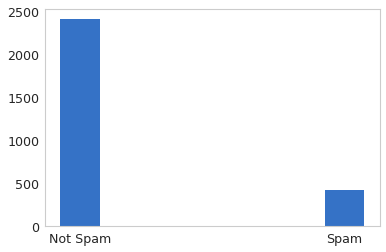

In [160]:
ind = np.arange(len(df["label"].unique()))
ham_height = df["label"].value_counts()[0]
spam_height = df["label"].value_counts()[1]
plt.grid()
plt.bar(ind, [ham_height, spam_height], width = 0.15)
plt.xticks((0,1), ('Not Spam',"Spam"))

# Balancing The Minority By Oversampling

In [166]:
from imblearn.over_sampling import SMOTE
sampler = SMOTE()
x_train_over, y_train_over = sampler.fit_resample(x_train,y_train)

# Visualizing The Balanced Dataset

([<matplotlib.axis.XTick at 0x7f51a8e6d5b0>,
 [Text(0, 0, 'Not Spam'), Text(1, 0, 'Spam')])

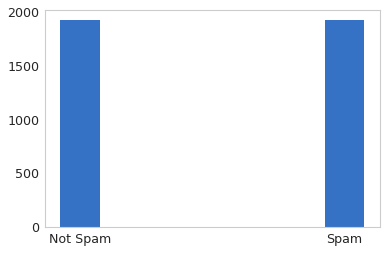

In [174]:
new_labels = pd.Series(y_train_over)
ind = np.arange(len(new_labels.unique()))
ham_height = new_labels.value_counts()[0]
spam_height = new_labels.value_counts()[1]
plt.grid()
plt.bar(ind, [ham_height, spam_height], width = 0.15)
plt.xticks((0,1), ('Not Spam',"Spam"))

# Building, Training The Model

In [177]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train_over, y_train_over)
y_pred = classifier.predict(x_test)

# Testing The Model Prediction

In [182]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[483   1]
 [ 15  67]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       484
           1       0.99      0.82      0.89        82

    accuracy                           0.97       566
   macro avg       0.98      0.91      0.94       566
weighted avg       0.97      0.97      0.97       566



# Testing Using K-fold Cross Validation

In [185]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,X = x_train_over, y = y_train_over, cv =10)

In [189]:
print("Average Accuracy : {}".format(accuracies.mean()))
print("Accuracy std : {}".format(accuracies.std()))

Average Accuracy : 0.98367471906332
Accuracy std : 0.02891747422528146


# Prediction Result

In [190]:
print(le.inverse_transform(y_pred))

['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham'
 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam'
 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham'
 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham'
 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'